<a href="https://colab.research.google.com/github/chnchryl/BasicWebApp/blob/master/StoryIllustration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
ENTITY = "ENTITY"
PARENT = "PARENT"
VALUE = "VALUE"
CLEAR = 'CLEAR'
REQUEST = 'REQUEST'
COMPLETE = 'COMPLETE'
ROTATE = "ROTATE"
TRANSLATE = "TRANSLATE"
SCALE = "SCALE"
TRANSFORM = "TRANSFORM"
INIT = "INIT"
END = "END"


In [2]:
from google.colab import files
input_file = files.upload()

Saving transformation_log.txt to transformation_log.txt


In [26]:
!pip install keras-tqdm

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold, cross_val_score

from keras.preprocessing.text import one_hot
from keras.layers.embeddings import Embedding
from keras_tqdm import TQDMNotebookCallback

from tqdm import tqdm_notebook
import json

VECTOR_DIMENSION = 8
VOCAB_SIZE = 50


In [0]:
class InputReader:
    UNK_TOKEN = '<UNK>'

    def __init__(self, filename):
        self.word2idx = {}
        self.idx2word = {0: self.UNK_TOKEN}
        self.input_data = self.load_input_data(filename)
        print(self.word2idx)
        print(self.idx2word)

    def add_word(self, word):
        if word not in self.word2idx:
            idx = len(self)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def __len__(self):
        return len(self.idx2word)

    def get_word(self, key: int):
        return self.idx2word[key]

    def get_word_index(self, key: str):
        return self.word2idx[key]

    def load_input_data(self, filename):
        input_data = []
        with open(filename) as input_file:
            for line in input_file.readlines():
                line_dict = json.loads(line)
                input_data.append(line_dict)
                self.add_word(line_dict[PARENT])
                self.add_word(line_dict[ENTITY])
        return input_data

    def fromdeg(d):
     r = d * np.pi / 180.
     return np.array([np.cos(r), np.sin(r)])

    def get_scale_rot_data(self):
        entity_labels = []
        scale_values = []
        for data in self.input_data:
            entity = self.get_word_index(data[ENTITY])
            parent = self.get_word_index(data[PARENT])
            
            entity_labels.append([entity, parent])
            # TODO: fix aspect ratio scaling for fabric (https://github.com/fabricjs/fabric.js/wiki/Preventing-object-modification)
            scale_values.append(np.array([data[TRANSFORM][SCALE][0], data[TRANSFORM][ROTATE]]))
        return np.array(entity_labels), np.array(scale_values)

# Baseline Model



In [0]:
def baseline_model(vector_dim=VECTOR_DIMENSION):
    embedding_length = 2
    input_dim = 2
    output_dim = 2
    vocab_size = 18

    model = Sequential()
    model.add(Embedding(vocab_size, vector_dim, input_length=embedding_length))
    model.add(Flatten())
    model.add(Dense(input_dim, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(output_dim, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

## Full Training

In [44]:
inputReader = InputReader('transformation_log.txt')

entity_labels, scale_rot_values = inputReader.get_scale_rot_data()
max_length = 2
padded_words = pad_sequences(entity_labels, maxlen=max_length, padding='post')

print(padded_words, scale_rot_values)

model = baseline_model()
print(model.summary())

{None: 1, 'bull': 2, 'cat': 3, 'bug': 4, 'bench': 5, 'boy': 6, 'cheese': 7, 'worm': 8, 'salamander': 9, 'rocket': 10, 'princess': 11, 'dress': 12, 'blobfish': 13, 'tree': 14, 'ninja': 15, 'rabbit': 16, 'cheetah': 17, 'duck': 18, 'strawberries': 19}
{0: '<UNK>', 1: None, 2: 'bull', 3: 'cat', 4: 'bug', 5: 'bench', 6: 'boy', 7: 'cheese', 8: 'worm', 9: 'salamander', 10: 'rocket', 11: 'princess', 12: 'dress', 13: 'blobfish', 14: 'tree', 15: 'ninja', 16: 'rabbit', 17: 'cheetah', 18: 'duck', 19: 'strawberries'}
[[ 2  1]
 [ 3  1]
 [ 4  1]
 [ 2  1]
 [ 5  1]
 [ 2  1]
 [ 5  1]
 [ 6  1]
 [ 7  1]
 [ 2  1]
 [ 5  1]
 [ 6  1]
 [ 7  1]
 [ 8  1]
 [ 9  1]
 [10  1]
 [ 9  1]
 [11  1]
 [12 11]
 [ 8  1]
 [13  1]
 [14  1]
 [15  1]
 [16  1]
 [17  1]
 [18  1]
 [ 7  1]
 [ 3  1]
 [19  1]] [[ 1.57123294  0.        ]
 [ 0.67835969  0.        ]
 [ 0.26166799  0.        ]
 [ 1.          0.        ]
 [ 1.02982281  0.        ]
 [ 1.          0.        ]
 [ 1.02982281  0.        ]
 [ 0.97303652  0.        ]
 [ 0.2507831

## Fitting

In [41]:
# fit the model
history = model.fit(padded_words, scale_values, epochs=256, verbose=0, validation_split=0.25, callbacks=[TQDMNotebookCallback()])
loss = model.evaluate(padded_words, scale_values, verbose=1)
print(f'Loss: {loss}')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



29/29 [==============================] - 0s 70us/step
Loss: 11.489418029785156


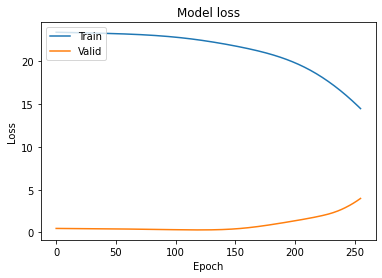

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()


In [43]:
predictions = model.predict(padded_words)
print(predictions)

[[0.8344199  1.960488  ]
 [0.5905321  1.3390889 ]
 [0.29586563 0.58797383]
 [0.8344199  1.960488  ]
 [0.7937232  1.8570033 ]
 [0.8344199  1.960488  ]
 [0.7937232  1.8570033 ]
 [0.713756   1.6532521 ]
 [0.29586563 0.58797383]
 [0.8344199  1.960488  ]
 [0.7937232  1.8570033 ]
 [0.713756   1.6532521 ]
 [0.29586563 0.58797383]
 [0.29586563 0.58797383]
 [0.6070713  1.38155   ]
 [2.9930153  7.4588575 ]
 [0.6070713  1.38155   ]
 [0.61609405 1.4045421 ]
 [0.29586563 0.58797383]
 [0.29586563 0.58797383]
 [0.2980432  0.5936328 ]
 [1.2694536  3.0686603 ]
 [1.3284869  3.2191548 ]
 [1.2733155  3.0786443 ]
 [1.3275142  3.2164788 ]
 [1.2850041  3.1083703 ]
 [0.29586563 0.58797383]
 [0.5905321  1.3390889 ]
 [1.2850041  3.1083703 ]]


## K-Fold Evaluation

In [0]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)
kfold = KFold(n_splits=2)
results = cross_val_score(estimator, padded_words, scale_values, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
14/14 [==============================] - 0s 9ms/step - loss: 0.9101
Epoch 2/100
14/14 [==============================] - 0s 1ms/step - loss: 0.9055
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 0.9009
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 0.8954
Epoch 5/100
14/14 [==============================] - 0s 1ms/step - loss: 0.8903
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 0.8846
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 0.8792
Epoch 8/100
14/14 [==============================] - 0s 1ms/step - loss: 0.8742
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 0.8684
Epoch 10/100
14/14 [==============================] - 0s 1ms/step - loss: 0.8625
Epoch 11/100
14/14 [==============================] - 0s 1ms/step - loss: 0.8569
Epoch 12/100
14/14 [==============================] - 0s 1ms/step - loss: 0.8509
Epoch 13/100
14/14 [=================